In [5]:
import csv
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon

#plot the poor housing conditions map
poorHouseCon = gpd.read_file('../Data/poorhousingcondition/Poor_Housing_Condition.shp')
poorHouseCon.head()

#get the 2010 census tract neighborhoods in Pittsburgh
cenTract = gpd.read_file('../Data/2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')

In [6]:
#Load in the CSV Bike Station Location Data
df = pd.read_csv('../Data/HRSQ12020.csv')

#combine the latitude and longitude to make coordinates
df['coordinates'] = df[['Longitude', 'Latitude']].values.tolist()

# Change the coordinates to a geoPoint
df['coordinates'] = df['coordinates'].apply(Point)

#fixing wrong negative value for Latitude
df.loc[df["Latitude"] == df["Latitude"].min()]
df.at[80, 'Latitude'] = 40.467715

crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
geobikes = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

len(df)

/Users/katelyncmorrison/opt/anaconda3/envs/fair_demand_prediction/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


100

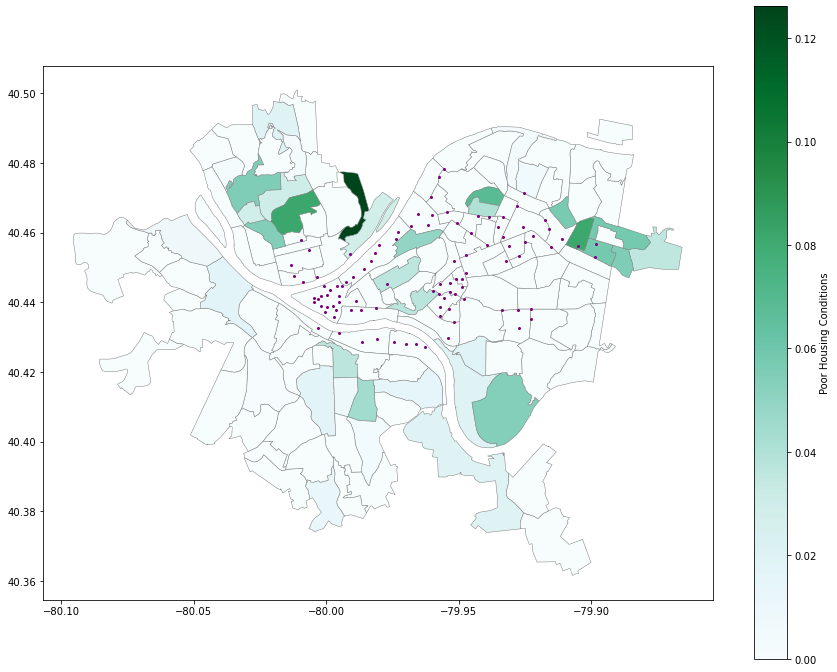

In [7]:
#get only the poor housing condition rate to join to other data frame
poorCond_data = pd.DataFrame(poorHouseCon['PPoorCon'])
poorCond_data = poorCond_data.join(poorHouseCon['TRACTCE'])
poorCond_data = poorCond_data.rename(columns={'TRACTCE': 'tractce10'})

cenTract = cenTract.merge(poorCond_data, on="tractce10")

#plotting the poor housing condition data on the pittsburgh neighborhood map (data from 2016)
ax = cenTract.plot(column="PPoorCon", cmap='BuGn', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, legend=True, legend_kwds={'label': "Poor Housing Conditions",'orientation': "vertical"})
    
#now adding the bike station location data on top of this map. 
geobikes.plot(ax=ax, color="Purple", markersize=4);

In [8]:
#find the number of stations in each tract
stationTracts = {}

#fill the dictionary with 0s
for idx, row in cenTract.iterrows():
    strPoint = row['tractce10']
    stationTracts[strPoint] = 0

#sum up the number of bike racks available total in that tract
for idx, row in df.iterrows():
    for index, rows in cenTract.iterrows():
        poly = rows['geometry']
        if row['coordinates'].within(poly):
            strPoint = rows['tractce10']
            rowNum = stationTracts.get(strPoint)    
            rowNum += row['NumRacks']
            stationTracts[strPoint] = rowNum

#add the sums to the GeoDataFrame to plot
cenTract['NumRacksTotal'] = 0
for idx, row in cenTract.iterrows():
    NumVal = stationTracts.get(row['tractce10'])
    cenTract.at[idx, 'NumRacksTotal'] = NumVal

cenTract.loc[cenTract['NumRacksTotal'] == cenTract['NumRacksTotal'].max()]

,objectid,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,aland10,...,sum_lowmod,sum_lowm_1,lowmodperc,lowmodpe_1,cdbg2018,Shape__Are,Shape__Len,geometry,PPoorCon,NumRacksTotal
6,7,42,003,020100,4,420030201004,Block Group 4,G5030,S,281715,...,1125,2875,39.130435,39.13,No,1.784591e+07,23034.929056,"POLYGON ((-79.99238 40.44484, -79.99233 40.444...",0.0,184


In [9]:
#find the centroids of each neighborhood for labeling
cenTract["center"] = cenTract["geometry"].centroid
map_points = cenTract.copy()
map_points.set_geometry("center", inplace = True)

/Users/katelyncmorrison/opt/anaconda3/envs/fair_demand_prediction/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Text(0.5, 0.98, 'Number of Racks Total in Each Neighborhood')

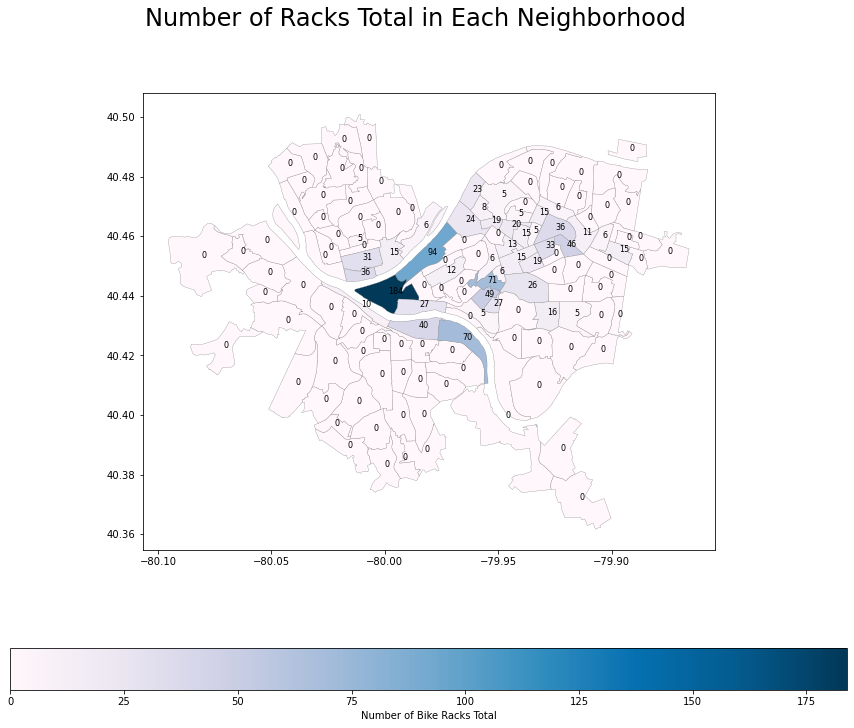

In [12]:
#plot the number of bikes racks in each tract as a range on the map
ax = cenTract.plot(column="NumRacksTotal", cmap='PuBu', figsize = (15, 12), edgecolor = "grey", linewidth = 0.3, legend=True, legend_kwds={'label': "Number of Bike Racks Total",'orientation': "horizontal"})
texts = []
#add object id labels
for x, y, label in zip(map_points.geometry.x, map_points.geometry.y, map_points["NumRacksTotal"]):
    texts.append(plt.text(x, y, label, fontsize = 8))
#save figure and label it
resultFig = ax.get_figure()
resultFig.suptitle('Number of Racks Total in Each Neighborhood', fontsize=24)
# resultFig.savefig("NumRacks.png")